In [1]:
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
import os 
import cv2
# mount drive- following tutorial at https://medium.com/ml-book/simplest-way-to-open-files-from-google-drive-in-google-colab-fae14810674
#from google.colab import drive
#drive.mount('/content/drive') 


<ipython-input-2-e48e28607776>:10: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  img1=rgb2gray(plt.imread(os.path.join(im_dir, fname1))); # read image 1
<ipython-input-2-e48e28607776>:11: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  img2=rgb2gray(plt.imread(os.path.join(im_dir, fname2))); # read image 2
<ipython-input-2-e48e28607776>:12: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  img3=rgb2gray(plt.imread(os.path.join(im_dir, fname3))); # read image 3


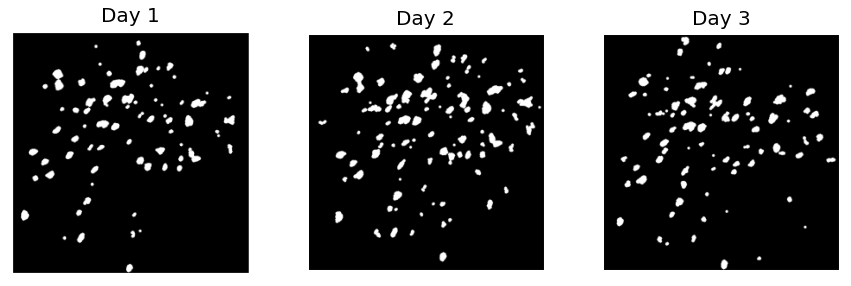

In [2]:
from skimage.util import img_as_ubyte, img_as_float
from skimage.color import rgb2gray, gray2rgb

im_dir='C:/Users/stuberadmin/Desktop/project_images' # image path to open

fname1='PL01_day1_binary.png'
fname2='PL01_day2_binary.png'
fname3='PL01_day3_binary.png'

img1=rgb2gray(plt.imread(os.path.join(im_dir, fname1))); # read image 1
img2=rgb2gray(plt.imread(os.path.join(im_dir, fname2))); # read image 2
img3=rgb2gray(plt.imread(os.path.join(im_dir, fname3))); # read image 3


fig, ax = plt.subplots(ncols=3, figsize=(15,6)) 
titles=('Day 1', 'Day 2', 'Day 3')
for axi, title in zip(ax,titles):
  axi.axis('off')
  axi.set_title(title, fontsize=20)

ax[0].imshow(img1, cmap='gray')
ax[1].imshow(img2, cmap='gray');
ax[2].imshow(img3, cmap='gray');

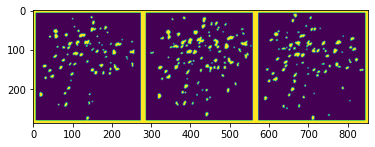

In [3]:
im=np.hstack((img1, img2, img3))
plt.imshow(im)

In [4]:
def draw_circle(event,x,y,flags,param):
    global mouseX,mouseY
    if event == cv2.EVENT_LBUTTONDBLCLK:
        #cv2.circle(img1,(x,y),5,(0,0,255),1) 
        #image, center_coordinates, radius, color, thickness
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(im,str(a),(x-4,y), font, 0.5,(0,0,255),2,cv2.LINE_AA)
        mouseX,mouseY = x,y
       
        
        

In [5]:
im=gray2rgb(im)
cv2.namedWindow('image1')
cv2.setMouseCallback('image1',draw_circle)
flag1=0
a=0;
b=1;
while(flag1<1):
    cv2.imshow('image1',im)
    k = cv2.waitKey(20) & 0xFF
    if k == 27:
        flag1=1
        break
    elif k == ord('a'):
        print (mouseX,mouseY)
        if b>2:
            a=a+1
            b=0
        b=b+1
    elif k == ord('q'):
        flag1=1
    
cv2.destroyAllWindows()

31 142
323 145
597 150
41 154
338 155
611 160
49 167
344 170
616 176
32 171
329 173
600 180
19 214
322 218
591 223
